In [16]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from sklearn import preprocessing
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.linear_model import LinearRegression
from theano import shared
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.11.4


# All Functions

In [2]:
#Random Data generator
def generate_data(n, rand_type, low=0, upper=1):
    if rand_type == 'int':
        data = np.random.randint(low, upper, n);
    elif rand_type == 'number':
        data = np.random.randn(n)
    return data

#Plot data
def plot_data(data):
    fig, ax = plt.subplots(figsize=(10, 5))
    data.plot(ax=ax)
    ax.set(ylabel='Islands')
    sns.despine()
    
#KDE plot
def kde_plot(data):
    az.plot_kde(data.values, rug=True)
    plt.yticks([0], alpha=0);
    
    
#prior predictive check
def prior_Predictive_Check(model):
    with model:
        prior_pred = pm.sample_prior_predictive()
    return prior_pred

#prior plot
def Prior_predictive_check_plot(y, prior_pred, y_var):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist([y.mean() for y in prior_pred[y_var]], bins=19, alpha=0.7)
    ax.axvline(data.mean().item())
    ax.set(title='Prior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
    
#Fitting the model
def fit_model(model, draws=10):
    with model:
    # Inference button (TM)
        trace = pm.sample(draws)
    return trace

#posterior predictive check
def post_Predictive_Check(model, trace, samples=10):
    with model:
        post_pred = pm.sample_posterior_predictive(trace, samples, model=model)
    return post_pred


#post plot
def Post_predictive_check_plot(y, post_pred, y_var):
    _, ax = plt.subplots(figsize=(10, 5))
    ax.hist([y.mean() for y in post_pred['y']], bins=19, alpha=0.5)
    ax.axvline(data.mean().item())
    ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
    
    
#posterior plot comparasion with observed data
def compare(post_pred, trace):
    data_ppc = az.from_pymc3(trace=trace, posterior_predictive=post_pred)
    ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
    #ax[0].legend(fontsize=15)
    fig, axs = plt.subplots(3)

The fundamental objective of Bayesian data analysis is to determine the posterior distribution. Bayesian models are also known as probabilistic models because they are built using probabilities. And Bayesian’s use probabilities as a tool to quantify uncertainty. Therefore, the answers we get are distributions not point estimates.

p(X | θ) is the likelihood,

p(θ) is the prior and

p(X) is a normalizing constant also known as the evidence or marginal likelihood

# Bayesian Approach Steps
Step 1: Establish a belief about the data, including Prior and Likelihood functions.

Step 2, Use the data and probability, in accordance with our belief of the data, to update our model, check that our model agrees with the original data.

Step 3, Update our view of the data based on our model.

# WorkFlow
1) Generating Data

2) Ploting the data and find out the distribution of data

3) Guassian inference

4) Build the model (decide proir distribution and likelihood distribution on given data)

5) Run the prior predictive check, usually we have less intuition about the prior data, so it is good to always check the prior data. It allows us to make sure the model can generate the types of data we expect to see.

6) Fit the model

7) Assess convergence

8) Run posterior predictive check

# Island Example

### 1) Generating Data

In [3]:
data = generate_data(1000, 'int' ,low=10, upper=100)

In [4]:
data = pd.DataFrame(data)

### 2) Ploting the data

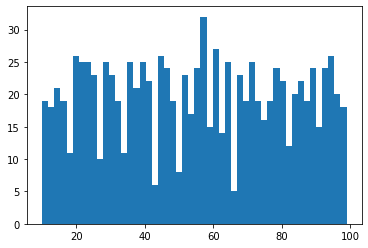

In [9]:
plt.hist(data, bins = 50)
plt.show()

###  3) Fitting distributions
The next step is to start fitting different distributions and finding out the best-suited distribution for the data.

The steps are:
    
1) Create a Fitter instance by calling the Fitter()

2) Supply the data (height) and distributions list if you have a basic idea of the distributions that might fit your data

3) Apply the .fit() method

4) Generate the fitted distribution summary using .summary() method

The Fitter class in the backend uses the Scipy library which supports 80 distributions and the Fitter class will scan all of them, call the fit function for you, ignoring those that fail or run forever and finally give you a summary of the best distributions in the sense of sum of the square errors.

,sumsquare_error,aic,bic,kl_div
beta,0.002765,919.608026,-12770.903815,inf
burr,0.002804,920.813081,-12756.885798,inf
lognorm,0.004036,939.052214,-12399.643670,inf
gamma,0.004039,939.020228,-12398.717218,inf
norm,0.004040,937.020168,-12405.540160,inf


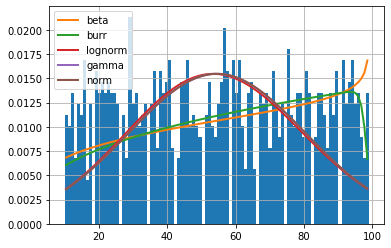

In [17]:
f = Fitter(data,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

Based on the sumsquare_error value the best distribution for the data is the beta and burr distribution. But as our data is randomly generated and we can't decide the distribution so we consider guassian 

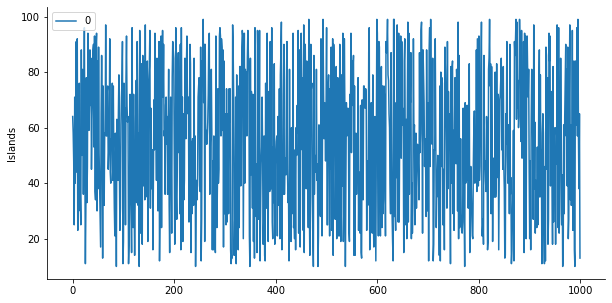

In [18]:
plot_data(data)

### 3) Gaussian Inferences
The KDE plot of the island data, shows a Gaussian-like distribution, except for about several dozens of data points that are far away from the mean.

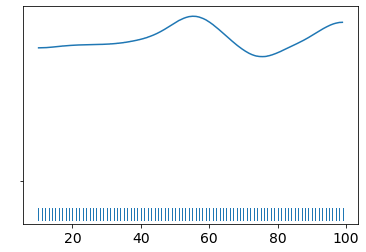

In [20]:
#plotting your data and check the pdf of your data
kde_plot(data)

Let’s assume that a Gaussian distribution is a proper description of the islands data. Since we do not know the mean or the standard deviation, we must set priors for both of them. Therefore, a reasonable model could be as follows.

### 4) Model

Choices of priors:

μ, mean of a population. Normal distribution, very wide. I do not know the possible values of μ, I can set priors reflecting my ignorance. From experience I know that number of population in each island can not be lower than 10 or higher than 100, so I set the boundaries of the uniform distribution to be 10 and 100.

σ, standard deviation of a population. Can only be positive, therefore use HalfNormal distribution. Again, very wide.

Choices for likelihood function:
    
y is an observed variable representing the data that comes from a normal distribution with the parameters μ and σ.
Draw 1000 posterior samples using NUTS sampling.

In [21]:
with pm.Model() as model_g:
    
    #priors
    μ = pm.Uniform('μ', lower=10, upper=100)
    σ = pm.HalfNormal('σ', sd=10)
    
    #likelihood
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    
    #Fit model (hit the Inference Button)
    #trace_g = pm.sample(500, tune=500)

### 5) Run prior predictive check

Without even fitting the model to our data, we generate new potential data from our priors. Usually we have less intuition about the parameter space, where we define our priors, and more intution about what data we might expect to see. A prior predictive check thus allows us to make sure the model can generate the types of data we expect to see.

In [22]:
prior_pred = prior_Predictive_Check(model_g)

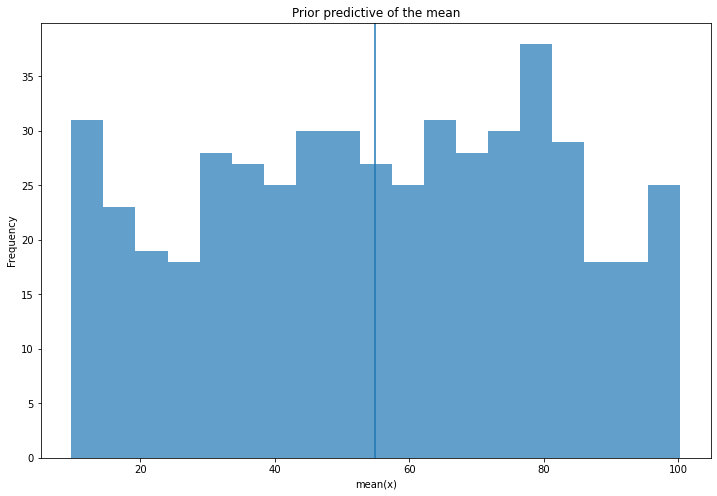

In [43]:
Prior_predictive_check_plot(y, prior_pred, 'y')

### 6) Fitting the model

In [24]:
trace = fit_model(model_g, draws=1000)

<ipython-input-24-57e519d65dd4>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\HP\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\HP\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\HP\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 915 seconds.


We plot the gaussian model trace. This runs on a Theano graph under the hood.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\HP\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


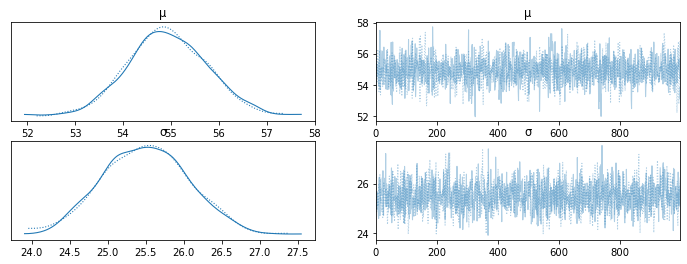

In [25]:
az.plot_trace(trace);

On the left, we have a KDE plot, — for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior.


There are a couple of things to notice here:

Our sampling chains for the individual parameters (left) seem well converged and stationary (there are no large drifts or other odd patterns).

The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters.

We can plot a joint distributions of parameters.

C:\Users\HP\anaconda3\lib\site-packages\arviz\plots\jointplot.py:145: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\HP\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


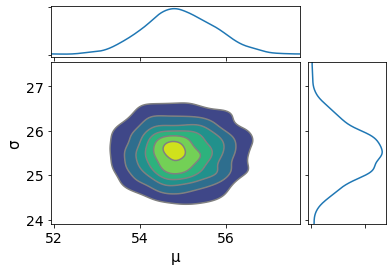

In [26]:
az.plot_joint(trace, kind='kde', fill_last=False);

I don’t see any correlation between these two parameters. This means we probably do not have collinearity in the model. This is good.

### 7) Summary of the posterior distribution for each parameter.

In [27]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\HP\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,54.926,0.843,53.398,56.570,0.020,0.014,1833.0,873.0,1.0
σ,25.505,0.569,24.458,26.556,0.014,0.010,1728.0,1549.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\HP\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


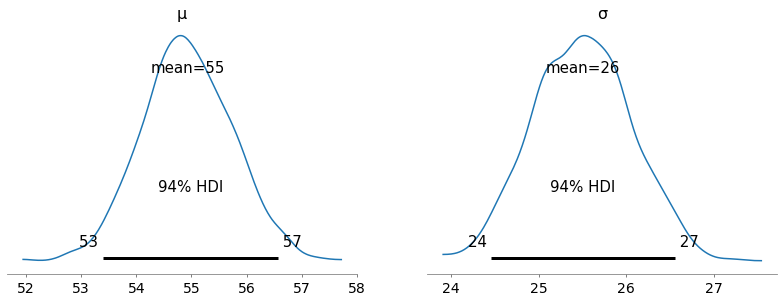

In [28]:
az.plot_posterior(trace);

Here we can interpret as such that there is 94% probability the belief is between 52  and 58 for the mean.

### 8) Verifying the convergence

We can verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence.

Got error No model on context stack. trying to find log_likelihood in translation.


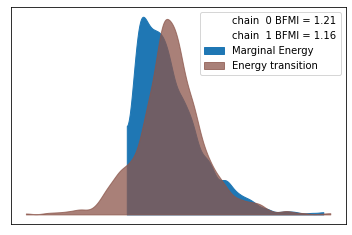

In [50]:
pm.plot_energy(trace);

Our model has converged well 

### 9) Posterior Predictive Checks
Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Now that we have computed the posterior, we are going to illustrate how to use the simulation results to derive predictions.

The following function will randomly draw 1000 samples of parameters from the trace. Then, for each sample, it will draw 25798 random numbers from a normal distribution specified by the values of μ and σ in that sample.

In [30]:
post_pred = post_Predictive_Check(model_g, trace, samples=1000)

C:\Users\HP\anaconda3\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


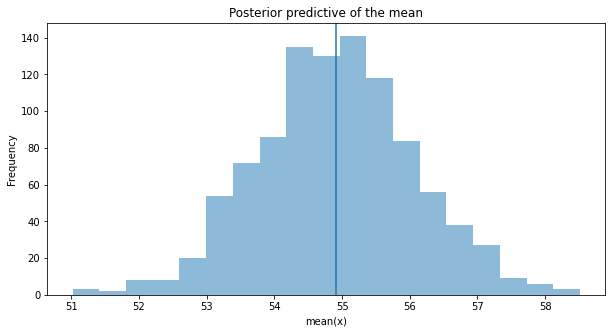

In [42]:
Post_predictive_check_plot(y, post_pred, 'y')

In the above histogram ,the inferred mean is very close to the actual mean.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\HP\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
C:\Users\HP\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


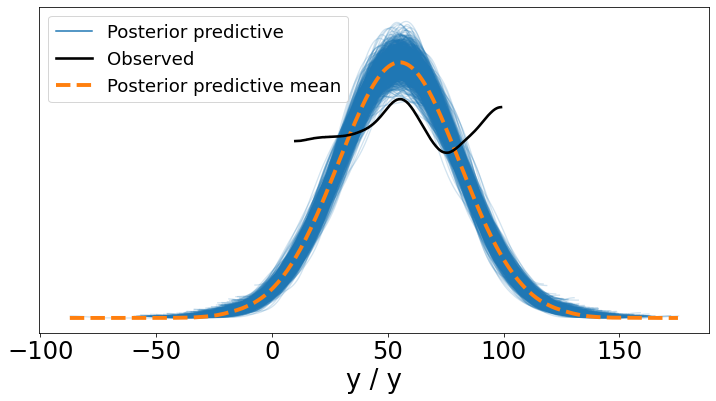

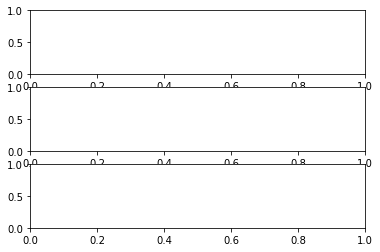

In [45]:
compare(post_pred, trace)

# Linear Regression Example

### 1) Data Generation

In [19]:
np.random.seed(123)
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]
# Size of dataset
size = 100
# Predictor variable
X1 = np.linspace(0, 1, size)
X2 = np.linspace(0,.2, size)
# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [20]:
data = pd.DataFrame(Y)

### 2) Plot Data

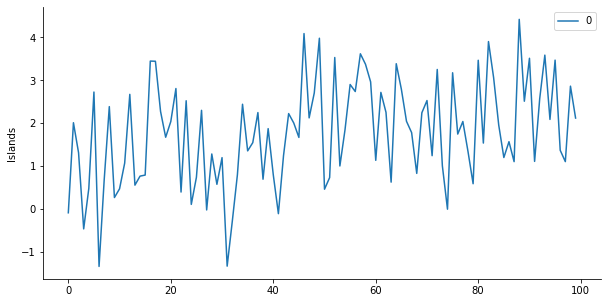

In [8]:
plot_data(data)

### 3)Fitting distributions

,sumsquare_error,aic,bic,kl_div
beta,3.174960,409.408956,-326.566845,inf
gamma,3.195914,420.745359,-330.514207,inf
lognorm,3.201367,420.495156,-330.343726,inf
norm,3.201442,417.793885,-334.946535,inf
burr,3.276280,407.633970,-323.425479,inf


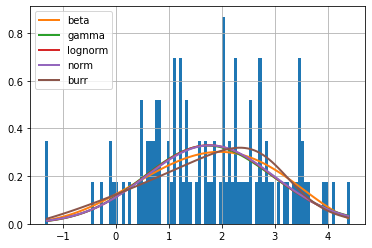

In [21]:
f = Fitter(data,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

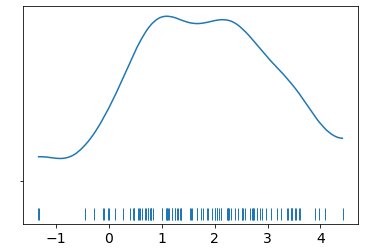

In [9]:
#plotting your data and check the pdf of your data
kde_plot(data)

 Let’s assume that a Gaussian distribution is a proper description of the data. Since we do not know the mean or the standard deviation, we must set priors for both of them. Therefore, a reasonable model could be as follows.

### 3) Model

Choices of priors:

μ, mean of a population. Normal distribution, very wide. I do not know the possible values of μ, I can set priors reflecting my ignorance.

σ, standard deviation of a data. Can only be positive, therefore use HalfNormal distribution. Again, very wide.

Choices for likelihood function:

Y is an observed variable representing the data that comes from a normal distribution with the parameters μ and σ. Draw 1000 posterior samples using NUTS sampling.

In [11]:
with pm.Model() as model_lr:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
   # Likelihood (sampling distribution) of observations
    y = pm.Normal('y', mu=mu, sd=sigma, observed=Y)


### 4) Prior predictive check

before fitting the model to our data, we generate new potential data from our priors. A prior predictive check thus allows us to make sure the model can generate the types of data we expect to see.

In [13]:
prior_pred = prior_Predictive_Check(model_lr)

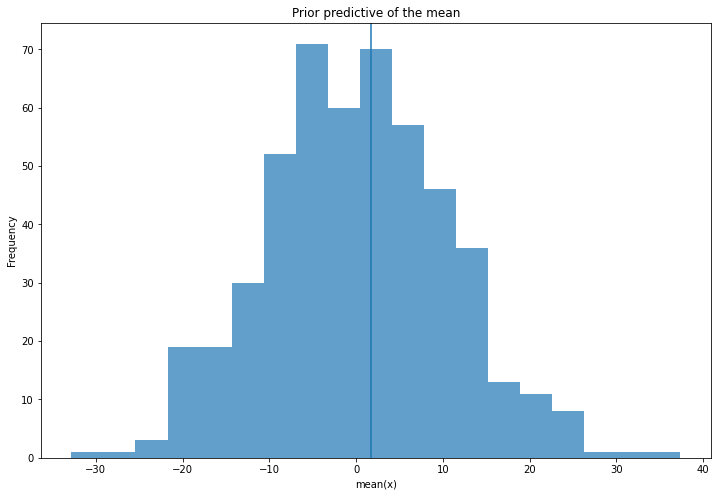

In [14]:
Prior_predictive_check_plot(y, prior_pred, 'y')

Data in above prior distribution seems to be very close to mean. so we will continue with same values of sigma and mean

### 5) Fitting the model

In [18]:
trace = fit_model(model_lr, draws=100)

<ipython-input-16-178c36f0ddaf>:39: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 1179 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\HP\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


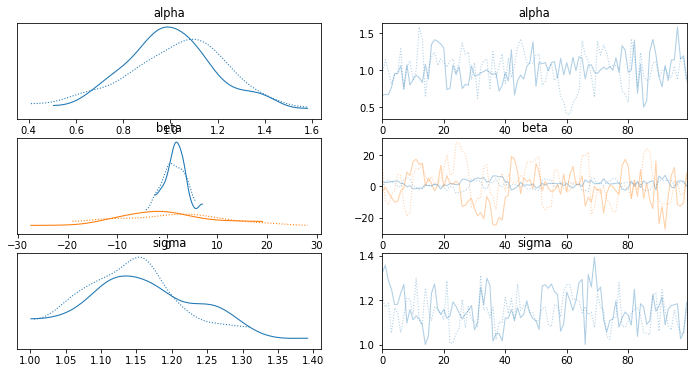

In [19]:
az.plot_trace(trace);

On the left, we have a KDE plot, — for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior.

There are a couple of things to notice here:

Our sampling chains for the individual parameters (left) seem it does not converged well and stationary (there are some large drifts).

The maximum posterior estimate of each variable (the peak in the left side distributions) is not very close to the true parameters.

We can plot a joint distributions of parameters.

In [21]:
az.plot_pair(trace, kind='kde', fill_last=False)

I don’t see any correlation between these two parameters. This means we probably do not have collinearity in the model. This is good

### 6) Summary of the posterior distribution for each parameter.

In [22]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.010,0.217,0.637,1.432,0.023,0.016,91.0,72.0,1.04
beta[0],1.465,2.344,-2.701,5.779,0.308,0.236,57.0,62.0,1.03
beta[1],0.221,11.246,-18.931,22.369,1.464,1.040,58.0,62.0,1.02
sigma,1.152,0.076,1.016,1.293,0.007,0.005,121.0,114.0,1.00


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\HP\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


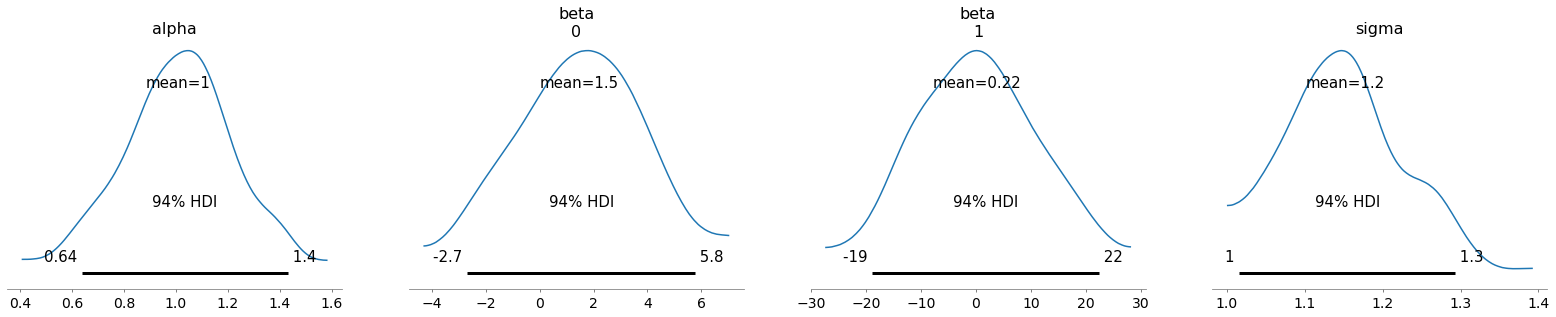

In [23]:
az.plot_posterior(trace);

Here we can interpret as such that there is 94% probability the belief is between 0.64 and 1.4 for the mean

### 7) Verifying the convergence

We can verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\HP\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


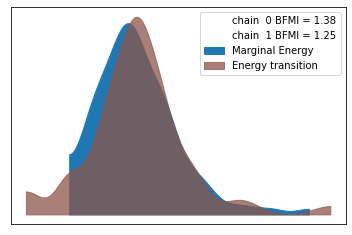

In [24]:
pm.plot_energy(trace);

### 8) Posterior Predictive Checks
Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Now that we have computed the posterior, we are going to illustrate how to use the simulation results to derive predictions.

The following function will randomly draw 1000 samples of parameters from the trace. Then, for each sample, it will draw 25798 random numbers from a normal distribution specified by the values of μ and σ in that sample.

In [25]:
post_pred = post_Predictive_Check(model_lr, trace, samples=100)

C:\Users\HP\anaconda3\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


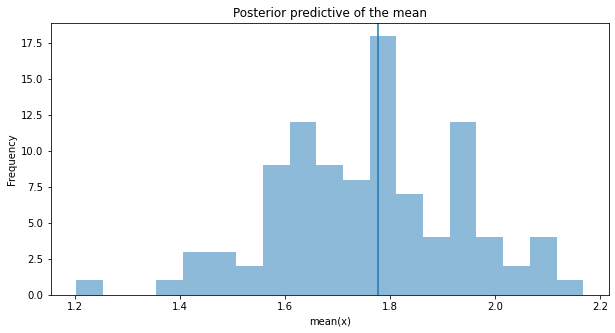

In [26]:
Post_predictive_check_plot(y, post_pred, 'y')

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\HP\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


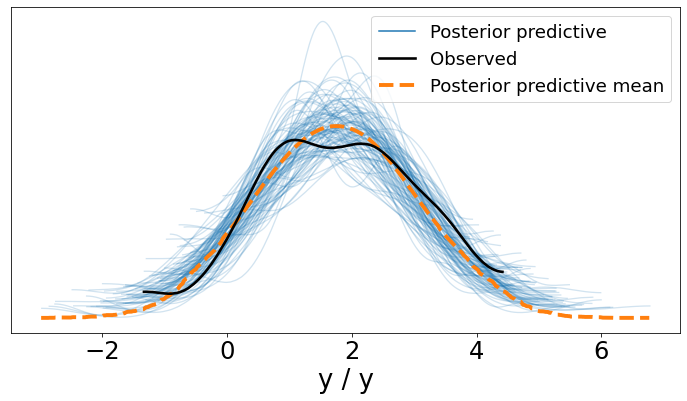

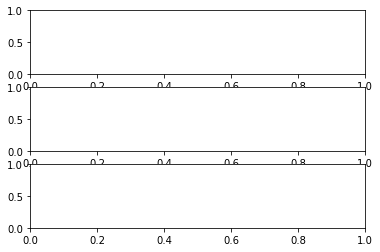

In [27]:
compare(post_pred, trace)